# First attempt on a classifier discriminating top-W scattering and ttX

We are mostly concerned about other tt+X backgrounds (ttZ and ttH).

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

## Binary classifier

In [3]:
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

sig_df = df[df['label']==0]
bkg_df = df[df['label']>0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 71461 events


In [4]:
eta_bins = [ x/2 for x in range(-10,11) ]
n_bins = [ x-0.5 for x in range(10) ]

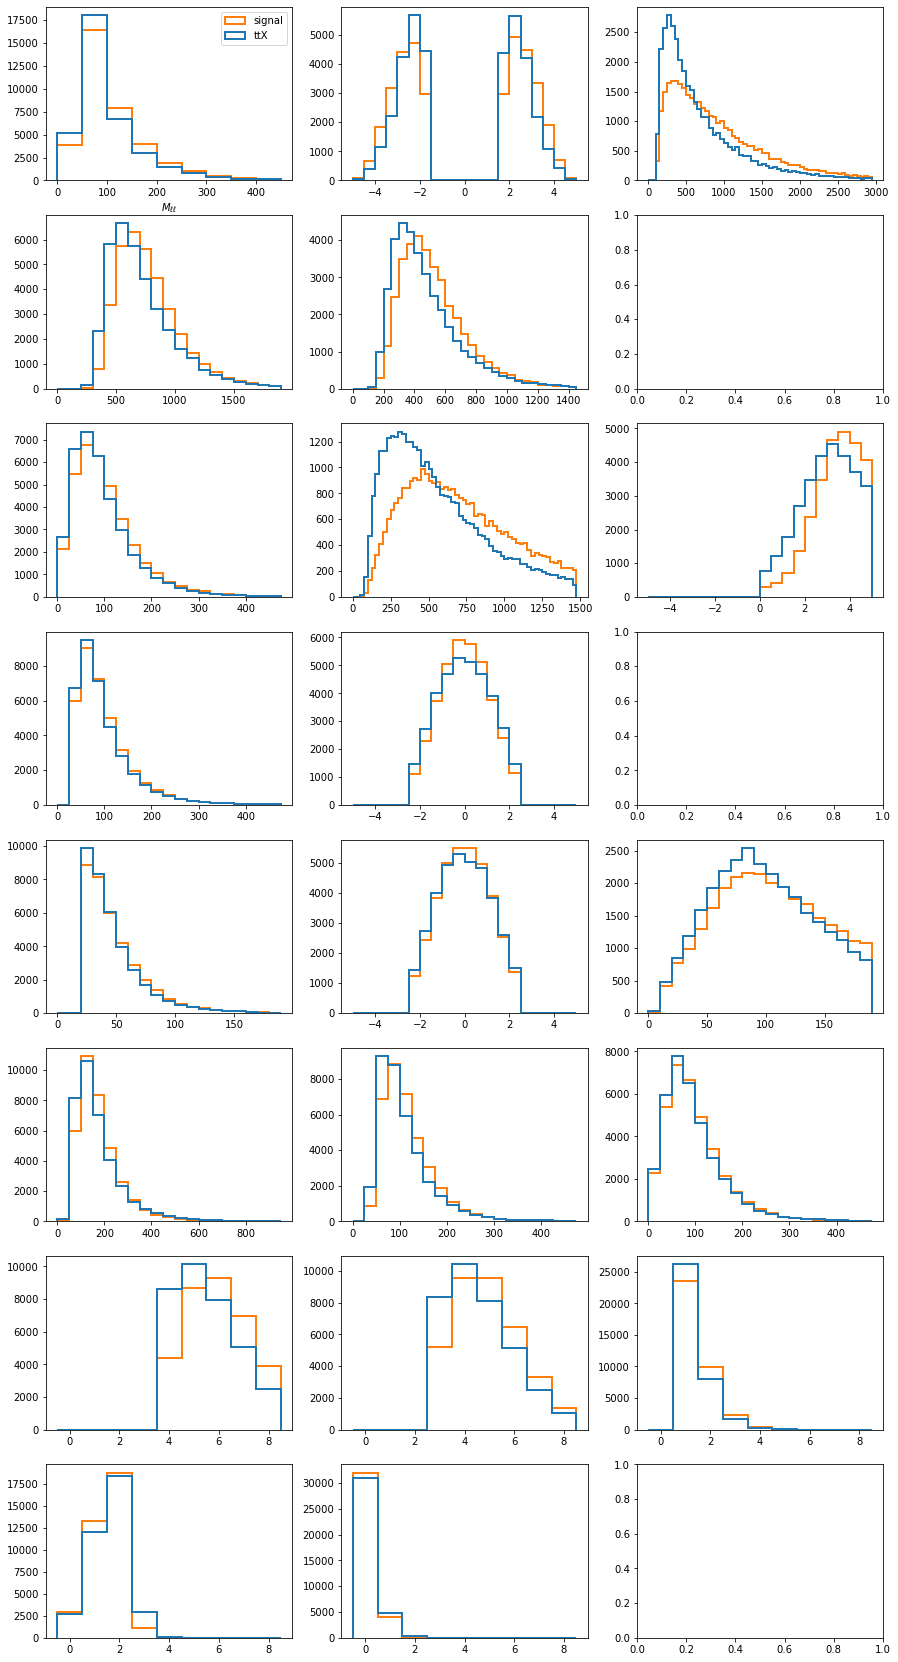

In [285]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(8,3, figsize=(15,30))

hist, bins, ax = axs[0,0].hist( [ X_bkg['fwd_jet_pt'].values, X_sig['fwd_jet_pt'].values ], range(0,500,50), histtype='step', linewidth=2, label=['ttX', 'signal'])
hist, bins, ax = axs[0,1].hist( [ X_bkg['fwd_jet_eta'].values, X_sig['fwd_jet_eta'].values ], eta_bins, histtype='step', linewidth=2) 
hist, bins, ax = axs[0,2].hist( [ X_bkg['fwd_jet_p'].values, X_sig['fwd_jet_p'].values ], range(0,3000,50), histtype='step', linewidth=2) 

hist, bins, ax = axs[1,0].hist( [ X_bkg['st'].values, X_sig['st'].values ], range(0,2000,100), histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg['ht'].values, X_sig['ht'].values ], range(0,1500,50), histtype='step', linewidth=2) 

hist, bins, ax = axs[2,0].hist( [ X_bkg['met'].values, X_sig['met'].values ], range(0,500,25), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg['mjj_max'].values, X_sig['mjj_max'].values ], range(0,1500,25), histtype='step', linewidth=2) 
hist, bins, ax = axs[2,2].hist( [ X_bkg['delta_eta_jj'].values, X_sig['delta_eta_jj'].values ], eta_bins, histtype='step', linewidth=2) 

hist, bins, ax = axs[3,0].hist( [ X_bkg['lead_lep_pt'].values, X_sig['lead_lep_pt'].values ], range(0,500,25), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg['lead_lep_eta'].values, X_sig['lead_lep_eta'].values ], eta_bins, histtype='step', linewidth=2) 

hist, bins, ax = axs[4,0].hist( [ X_bkg['sublead_lep_pt'].values, X_sig['sublead_lep_pt'].values ], range(0,200,10), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg['sublead_lep_eta'].values, X_sig['sublead_lep_eta'].values ], eta_bins, histtype='step', linewidth=2) 
hist, bins, ax = axs[4,2].hist( [ X_bkg['dilepton_mass'].values, X_sig['dilepton_mass'].values ], range(0,200,10), histtype='step', linewidth=2) 

hist, bins, ax = axs[5,0].hist( [ X_bkg['lead_jet_pt'].values, X_sig['lead_jet_pt'].values ], range(0,1000,50), histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg['sublead_jet_pt'].values, X_sig['sublead_jet_pt'].values ], range(0,500,25), histtype='step', linewidth=2) 
hist, bins, ax = axs[5,2].hist( [ X_bkg['dilepton_pt'].values, X_sig['dilepton_pt'].values ], range(0,500,25), histtype='step', linewidth=2) 

hist, bins, ax = axs[6,0].hist( [ X_bkg['n_jet'].values, X_sig['n_jet'].values ], n_bins, histtype='step', linewidth=2) 
hist, bins, ax = axs[6,1].hist( [ X_bkg['n_central'].values, X_sig['n_central'].values ], n_bins, histtype='step', linewidth=2) 
hist, bins, ax = axs[6,2].hist( [ X_bkg['n_fwd'].values, X_sig['n_fwd'].values ], n_bins, histtype='step', linewidth=2) 

hist, bins, ax = axs[7,0].hist( [ X_bkg['n_tau'].values, X_sig['n_tau'].values ], n_bins, histtype='step', linewidth=2) 
hist, bins, ax = axs[7,1].hist( [ X_bkg['n_track'].values, X_sig['n_track'].values ], n_bins, histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
#axs[0,1].set_xlabel(r'$N_{jet}$')
#axs[1,0].set_xlabel(r'$S_{T}$')
#axs[1,1].set_xlabel(r'$H_{T}$')
#axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
#axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
#axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
#axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
#axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
#axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
#axs[1,0].legend()
#axs[2,0].legend()
#axs[3,0].legend()
#axs[4,0].legend()

In [297]:
X_train = robust_scale(X_train, quantile_range=(10.0, 90.0))
X_test = robust_scale(X_test, quantile_range=(10.0, 90.0))

In [298]:
epochs = 50
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=20, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 20)                440       
_________________________________________________________________
dense_86 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_87 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 41        
Total params: 2,961
Trainable params: 2,961
Non-trainable params: 0
_________________________________________________________________


In [299]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    #validation_split=validation_split,
    verbose=0,
    callbacks=[KerasLearningCurve()]
)


In [300]:
#model.save( 'data/training.h5', include_optimizer=False )
model.save_weights( 'data/ttX_binary_weights.h5' )
model.save( 'data/ttX_binary_training.h5' )

Didn't find validation loss


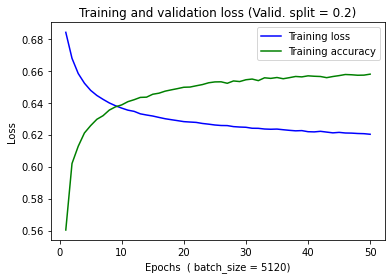

In [305]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

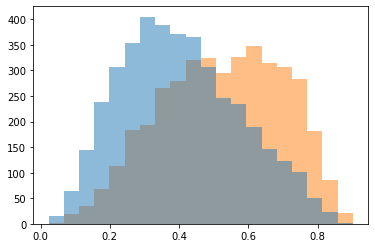

In [301]:
loaded_model = tf.keras.models.load_model('data/ttX_binary_training.h5')

# use the model to predict whether an event is signal or background
y_test_pred = loaded_model.predict( X_test  )

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].flatten(), y_test_pred[y_test==1].flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

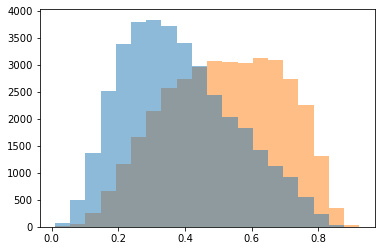

In [302]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = loaded_model.predict( X_train )

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].flatten(), y_train_pred[y_train==1].flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

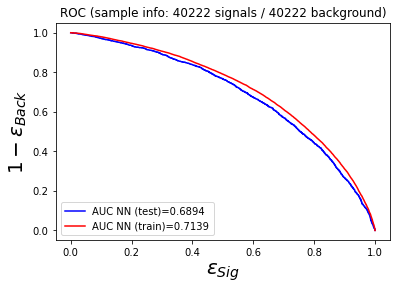

In [304]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


In [14]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

# Multiclassifier

In [5]:
from keras.utils import np_utils
from sklearn.preprocessing import robust_scale

In [6]:
variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

In [7]:
## filter some data
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

labels = df['label'].values

X = df[(labels<4)][variables]
labels = labels[labels<4]

In [8]:
n_rows = len(variables)/3
X_norm_plot = robust_scale(df[variables], quantile_range=(10.0, 90.0))

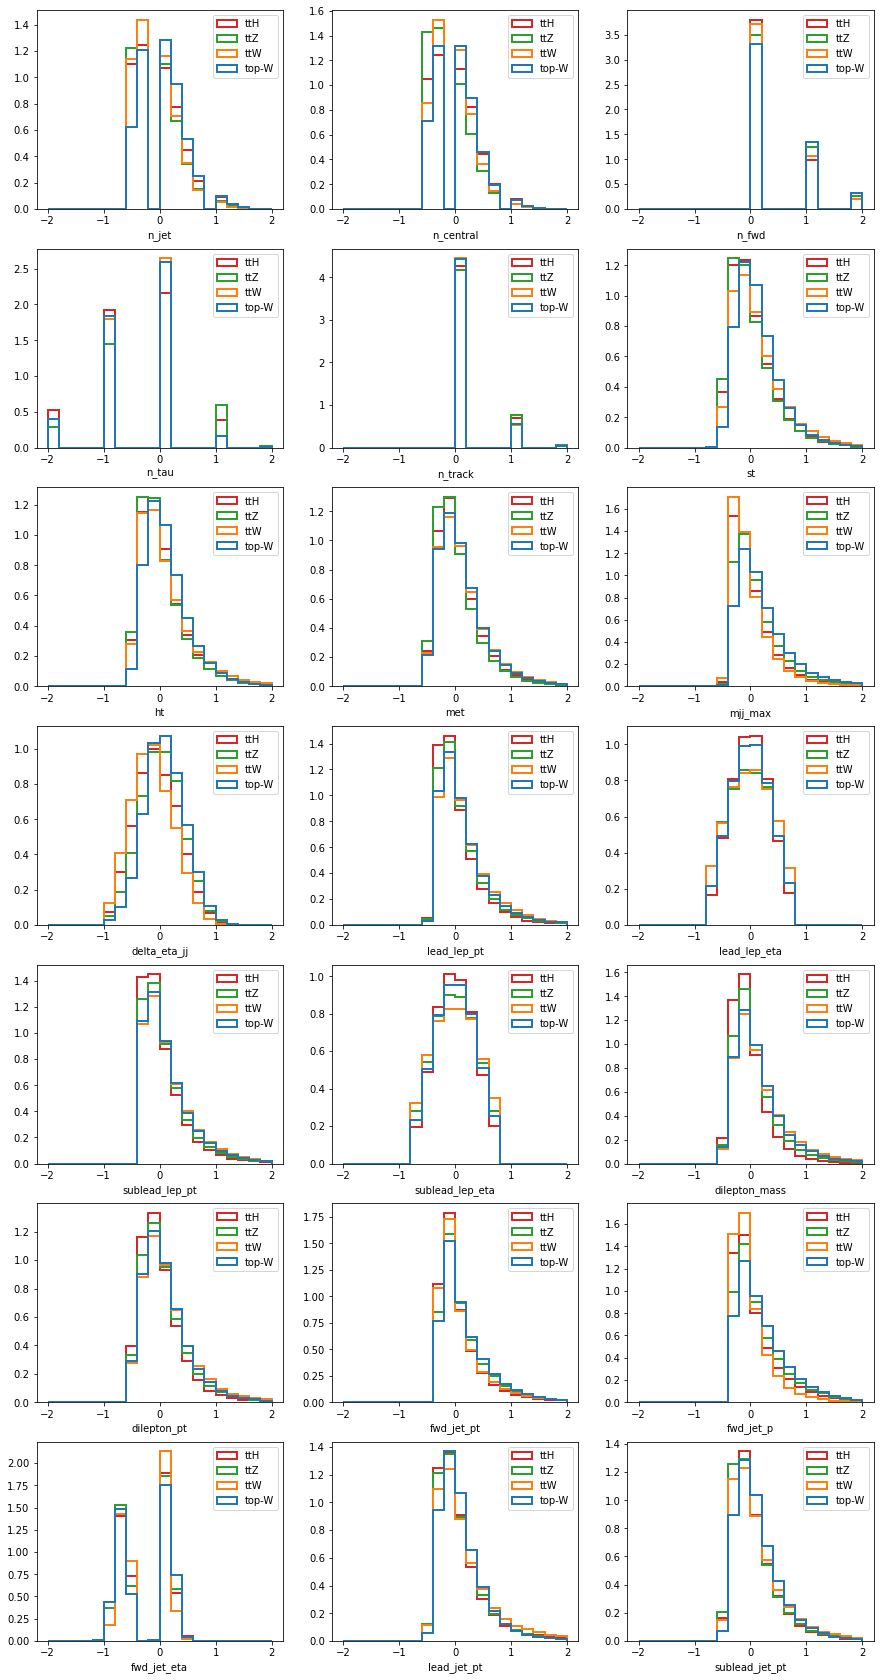

In [9]:
n_rows = len(variables)/3
X_norm_plot = robust_scale(df[variables], quantile_range=(10.0, 90.0))

bins = [ (x-10)/5 for x in range(21) ]

fig, axs = plt.subplots(int(n_rows),3, figsize=(15,30))

for i, var in enumerate(variables):
    i
    hist, bins, ax = axs[int(i/3),int(i%3)].hist( 
        [ X_norm_plot[:,i][labels==0], X_norm_plot[:,i][labels==1], X_norm_plot[:,i][labels==2], X_norm_plot[:,i][labels==3] ],
         bins,
         density=True,
         histtype='step', linewidth=2, label=['top-W', 'ttW', 'ttZ', 'ttH'])
    axs[int(i/3),int(i%3)].set_xlabel(var)
    axs[int(i/3),int(i%3)].legend()



In [10]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
encoder.fit(labels)
dummy_y = np_utils.to_categorical(labels)

dummy_y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

### Normalize - I guess there's a lot of room for improvement

In [11]:
X_mean, X_std = X.mean(), X.std()

#X -= X_mean
#X /= X_std

X

,n_jet,n_central,n_fwd,n_tau,n_track,st,ht,met,mjj_max,delta_eta_jj,...,lead_lep_eta,sublead_lep_pt,sublead_lep_eta,dilepton_mass,dilepton_pt,fwd_jet_pt,fwd_jet_p,fwd_jet_eta,lead_jet_pt,sublead_jet_pt
0,5.0,4.0,1.0,1.0,0.0,603.602295,391.968750,62.585217,368.965240,3.145996,...,1.115479,70.047409,-0.677734,199.537567,74.193604,42.18750,263.995209,-2.520508,138.7500,117.1250
1,7.0,6.0,1.0,2.0,2.0,485.281250,315.406250,59.615356,694.640930,5.597168,...,1.331543,39.199390,0.845947,105.939903,40.047340,53.93750,665.425720,-3.204102,65.0000,60.1250
2,7.0,7.0,1.0,1.0,0.0,799.454773,566.859375,103.858772,141.795456,1.434937,...,0.697754,27.180475,0.270386,107.470039,74.399353,46.46875,192.234604,2.098145,170.7500,106.8750
3,7.0,6.0,1.0,1.0,0.0,492.311096,391.375000,17.643785,1152.397949,6.084717,...,-0.949707,24.050077,-1.166748,56.514370,61.734516,76.06250,2362.731689,4.128906,90.6875,76.0625
4,7.0,5.0,1.0,1.0,1.0,740.923279,488.609375,162.013916,430.881622,4.635254,...,0.456055,42.268986,0.071655,91.636940,7.778562,79.75000,251.587494,1.815918,153.2500,140.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192779,4.0,4.0,1.0,2.0,1.0,312.655853,188.625000,27.479507,270.580139,3.122559,...,1.446289,28.744270,0.533569,96.558769,41.691742,72.56250,282.817291,2.036621,72.5625,45.8750
192780,6.0,5.0,2.0,2.0,0.0,937.896118,606.187500,115.848907,943.774658,3.740356,...,-1.071533,42.903084,-0.665161,145.510178,163.293106,100.75000,955.029358,2.939453,206.5000,100.7500
192781,6.0,6.0,1.0,3.0,0.0,658.786499,453.968750,129.371658,282.062225,2.512329,...,1.594727,27.898212,-1.066162,133.346405,65.813950,68.25000,221.744492,1.846924,144.8750,101.8125
192782,8.0,6.0,1.0,2.0,0.0,791.135010,614.578125,89.526657,782.918640,5.403809,...,0.176819,36.861618,-0.598389,45.445484,81.713463,88.18750,523.118713,-2.466309,131.2500,116.5000


In [12]:
X_norm = robust_scale(X, quantile_range=(10.0, 90.0))
X_norm

array([[-0.25      , -0.25      ,  0.        , ..., -0.67181797,
        -0.0440466 ,  0.15320403],
       [ 0.25      ,  0.25      ,  0.        , ..., -0.78053895,
        -0.37936914, -0.29462313],
       [ 0.25      ,  0.5       ,  0.        , ...,  0.06274753,
         0.10144928,  0.0726737 ],
       ...,
       [ 0.        ,  0.25      ,  0.        , ...,  0.02279258,
        -0.01619778,  0.03289958],
       [ 0.5       ,  0.25      ,  0.        , ..., -0.66319795,
        -0.0781472 ,  0.14829364],
       [ 0.5       , -0.5       ,  0.        , ..., -0.815252  ,
         0.32594487,  0.27203535]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, dummy_y, train_size= int( 0.9*dummy_y.shape[0] ), random_state=42 )

In [14]:
input_dim = len(variables)
out_dim = len(dummy_y[0])

print (len(variables))

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(2*input_dim, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(50, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add(tf.keras.layers.Dense(50, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(40, activation='relu'))
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    
    #opt = tf.keras.optimizers.SGD(lr=0.1)
    #opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.RMSprop(lr=0.001)
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model
 

model = baseline_model()
model.summary()
    


21
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                924       
_________________________________________________________________
batch_normalization (BatchNo (None, 42)                168       
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2150      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)               

In [15]:
np.unique(dummy_y, axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [16]:
from sklearn.utils import compute_class_weight

y_train_int = np.argmax(y_train, axis=1) # back to integers from one hot
y_test_int = np.argmax(y_test, axis=1) # back to integers from one hot

classWeight = compute_class_weight('balanced', classes=np.unique(y_train_int, axis=0), y=y_train_int) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.6746861924686193,
 1: 1.1456710071049365,
 2: 0.9200604517976455,
 3: 1.7918146893588895}

In [17]:
from ML.lrcurve import KerasLearningCurve

epochs = 200
batch_size = 5120
#batch_size = 1000
validation_split = 0.2

history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    #validation_split = validation_split,
    verbose = 0,
    class_weight = classWeight,
    callbacks = [KerasLearningCurve()]
)

In [18]:
pred_train = model.predict( X_train )
pred_test = model.predict( X_test )

In [19]:
def simpleAccuracy(pred, dummy_y):
    pred_Y = np.argmax(pred, axis=1)
    true_Y = np.argmax(dummy_y, axis=1)
    
    # this gives the measure of correctly tagged events, over the total
    return sum(pred_Y == true_Y)/len(true_Y)
    

In [20]:
simpleAccuracy(pred_train, y_train)

0.44312267657992566

In [21]:
simpleAccuracy(pred_test, y_test)

0.437522693085741

In [20]:
simpleAccuracy(pred_train[y_train_int==0], y_train[y_train_int==0])

0.46201601951165433

In [21]:
simpleAccuracy(pred_test[y_test_int==0], y_test[y_test_int==0])

0.46945182323110357

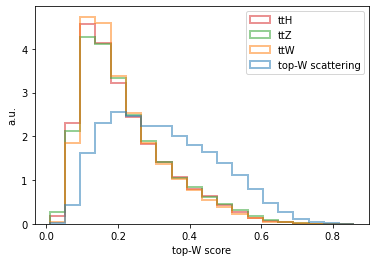

In [22]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred_train[:,0][y_train_int==0],
     pred_train[:,0][y_train_int==1],
     pred_train[:,0][y_train_int==2],
     pred_train[:,0][y_train_int==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5, density=True) 

plt.xlabel('top-W score')
plt.ylabel('a.u.')
plt.legend()

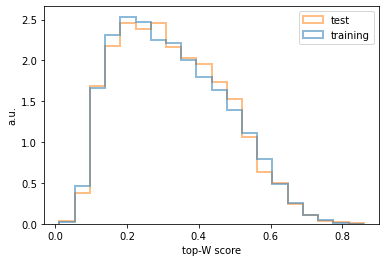

In [23]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred_train[:,0][y_train_int==0],
      pred_test[:,0][y_test_int==0],
    ], 
    xbin,
    log=False,
    label=['training' ,'test'], histtype='step', linewidth=2, alpha=0.5, density=True) 

plt.xlabel('top-W score')
plt.ylabel('a.u.')
plt.legend()

In [28]:
def getScore(signal=0):

    xbin = 20
    hist, bins, ax = plt.hist(
        [ pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==0)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==1)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==2)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==3)],
        ], 
        xbin,
        log=False,
        label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5, density=True) 
    
    plt.xlabel('top-W score')
    plt.ylabel('a.u.')
    plt.legend()

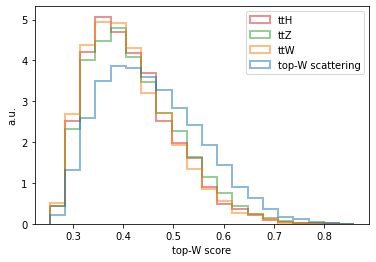

In [29]:
getScore(0)

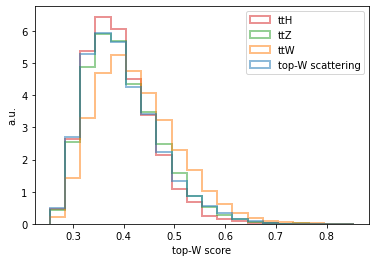

In [30]:
getScore(1)

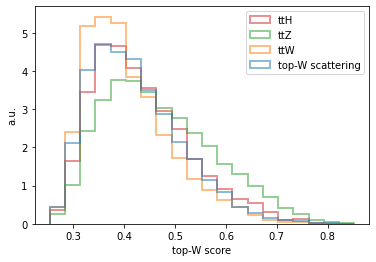

In [31]:
getScore(2)

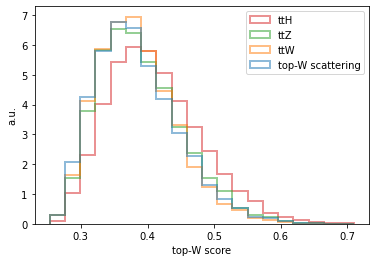

In [32]:
getScore(3)

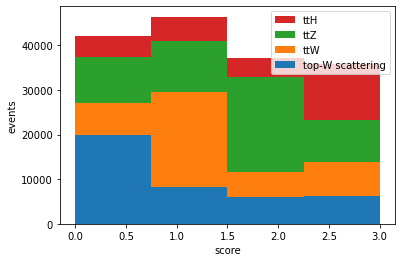

In [179]:
xbin = 4
hist, bins, ax = plt.hist(
    [ np.argmax(pred, axis=1)[(labels==0)],
     np.argmax(pred, axis=1)[(labels==1)],
     np.argmax(pred, axis=1)[(labels==2)],
     np.argmax(pred, axis=1)[(labels==3)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='stepfilled', linewidth=2, stacked=True) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

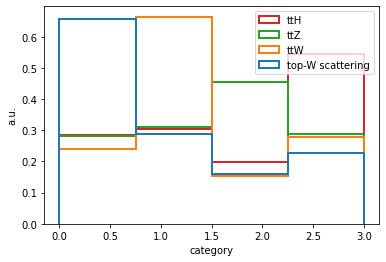

In [256]:
xbin = 4
hist, bins, ax = plt.hist(
    [ np.argmax(pred_test, axis=1)[(y_test_int==0)],
     np.argmax(pred_test, axis=1)[(y_test_int==1)],
     np.argmax(pred_test, axis=1)[(y_test_int==2)],
     np.argmax(pred_test, axis=1)[(y_test_int==3)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

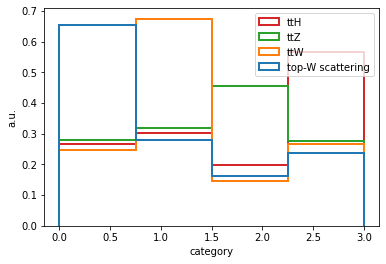

In [257]:
xbin = 4
hist, bins, ax = plt.hist(
    [ np.argmax(pred_train, axis=1)[(y_train_int==0)],
     np.argmax(pred_train, axis=1)[(y_train_int==1)],
     np.argmax(pred_train, axis=1)[(y_train_int==2)],
     np.argmax(pred_train, axis=1)[(y_train_int==3)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

In [278]:
def getROC(signal=0):

    y_test_binary = (y_test_int!=signal)*0 + (y_test_int==signal)*1
    y_train_binary = (y_train_int!=signal)*0 + (y_train_int==signal)*1

    fpr_test, tpr_test, thresholds_test = roc_curve( y_test_binary, pred_test[:,signal] )
    auc_val_test = auc(fpr_test, tpr_test)

    plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


    fpr_train, tpr_train, thresholds_test = roc_curve( y_train_binary, pred_train[:,signal]  )
    auc_val_train = auc(fpr_train, tpr_train)

    plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

    plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
    plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
    plt.legend(loc ='lower left')

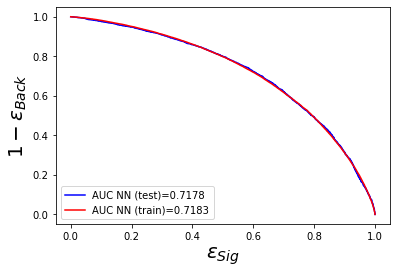

In [279]:
getROC(0)

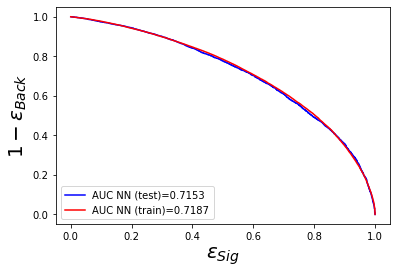

In [280]:
getROC(1)

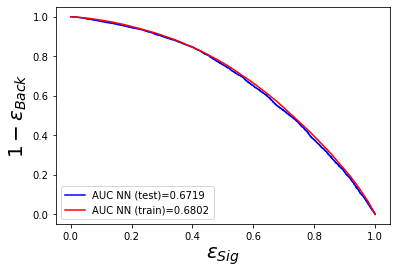

In [281]:
getROC(2)

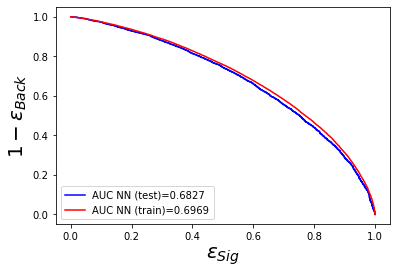

In [282]:
getROC(3)

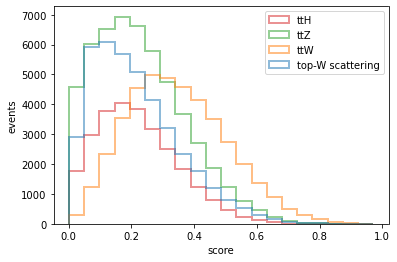

In [89]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,1][labels==0],
     pred[:,1][labels==1],
     pred[:,1][labels==2],
     pred[:,1][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

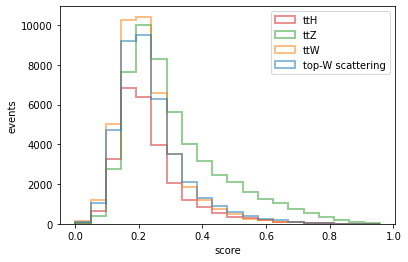

In [53]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,2][labels==0],
     pred[:,2][labels==1],
     pred[:,2][labels==2],
     pred[:,2][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

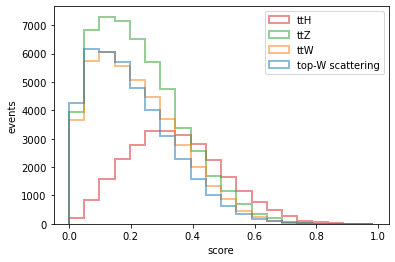

In [54]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,3][labels==0],
     pred[:,3][labels==1],
     pred[:,3][labels==2],
     pred[:,3][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

In [ ]:

sig_df = df[df['label']==0]
bkg_df = df[df['label']==3]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = [
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'n_jet',
    'n_central',
    'n_fwd',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'fwd_jet_pt',
    #'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

# BDT check

In [35]:
import xgboost as xgb

In [37]:
sig_df = df[df['label']==0]
bkg_df = df[df['label']>0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 40222 events


In [38]:
train = xgb.DMatrix(data=X_train,label=y_train,
                    missing=-999.0,feature_names=variables)
test = xgb.DMatrix(data=X_test,label=y_test,
                   missing=-999.0,feature_names=variables)

In [74]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 4  # maximum depth of a tree
#param['subsample']        = 0.8 # fraction of events to train tree on
#param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [75]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [76]:
print(booster.eval(test))

[0]	eval-error:0.347048	eval-logloss:0.626668	eval-rmse:0.467329


In [77]:
predictions = booster.predict(test)

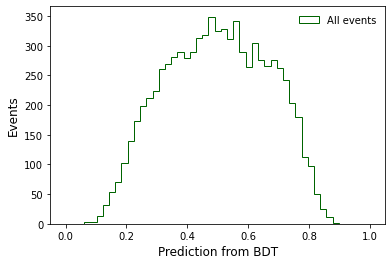

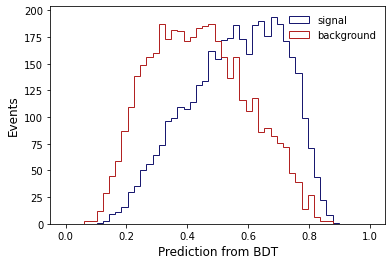

In [78]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

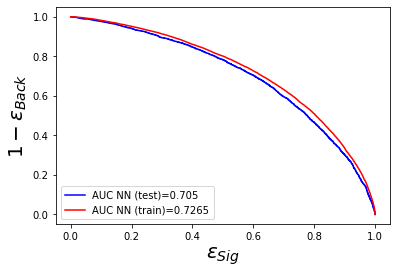

In [79]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, booster.predict(test) )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, booster.predict(train)  )
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')

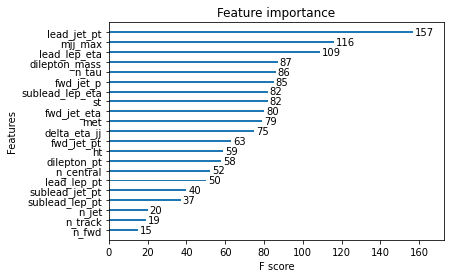

In [80]:
xgb.plot_importance(booster,grid=False);

## Multiclassifier example

[from here](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)

In [52]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv

--2021-02-16 14:29:59--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4549 (4.4K) [text/plain]
Saving to: ‘iris.csv’

100%[======================================>] 4,549       --.-K/s   in 0s      

2021-02-16 14:29:59 (32.5 MB/s) - ‘iris.csv’ saved [4549/4549]



In [54]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset
dataframe = pandas.read_csv("iris.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
 
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
model = baseline_model()

In [55]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(
    X,
    dummy_y,
    epochs = 200,
    batch_size = 5,
    #validation_split = validation_split,
    verbose = 0,
    callbacks = [KerasLearningCurve()]
)



In [22]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.67% (5.37%)
